# 바다나우 어텐션을 사용한 seq2seq 만들기

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## 데이터 로드

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


## 전처리

In [ ]:
# 유니코드를 아스키로 변환
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # 단어와 특수 문자 사이에 공백 넣기
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # 영어와 일부 특수문자(a-z, A-Z, ".", "?", "!", ",")를 제외하고는 전부 공백으로 변환
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # 문장의 시작과 끝에 <start> 토큰화 <end> 토큰 추가
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# 임의 선정한 문장에 대해서 전처리 결과 확인
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


## 토큰화 / 정수 인코딩 / 패딩

In [ ]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
# 지금까지 선언한 전처리 함수들을 실제 데이터셋에 적용한다면?
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
# 토큰화 / 정수 인코딩 / 패딩을 하는 함수
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
# 입력된 데이터셋에 대해서 토큰화 / 정수 인코딩 / 패딩을 수행
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# 샘플 수는 3만개로 제한하며
# 실제로 토큰화, 정수 인코딩, 패딩을 수행
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 최대 길이 계산
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# 8:2 비율로 분할
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 샘플 개수
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
input_tensor_train[0]

array([   1,    4, 2991, 1552,   10,   41,    3,    2,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
target_tensor_train[0]

array([   1,    5,  452, 1000,   45,    3,    2,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
input_tensor_val[0]

array([  1,   6,  46, 106, 863,   5,   2,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [ ]:
target_tensor_val[0]

array([  1,  60, 180,  15,  72,  17,   7,   2,   0,   0,   0], dtype=int32)

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> tom
2991 ----> seguia
1552 ----> llamando
10 ----> a
41 ----> mary
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
452 ----> kept
1000 ----> calling
45 ----> mary
3 ----> .
2 ----> <end>


## 텐서플로우 데이터셋 생성

In [ ]:
# 하이퍼파라미터 정의
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

# 단어 집합의 크기 정의
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# 첫번째 배치에 대해서 크기 출력
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 인코더 구현

In [ ]:
# 인코더 구현
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    # 선언부
    self.batch_sz = batch_sz
    self.enc_units = enc_units

    # 임베딩 층
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # GRU
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True, # 인코더의 모든 히든스테이트를 사용.
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  # 함수형 API와 유사하게 실제 동작은 이곳에서 정의
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  # 초기 은닉 상태는 제로 벡터로 사용
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
# 인코더 구현
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# 제로 벡터 생성
sample_hidden = encoder.initialize_hidden_state()

# 임의의 테스트 입력과 제로 벡터를 입력
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

# (64, 16, 1024)는 각각 (배치 크기, 문장 길이, 은닉 상태의 차원)
# (64, 1024)는 각각 (배치 크기, 은닉 상태의 차원)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


## 바다나우 어텐션 구현

In [ ]:
# 바다나우 어텐션 구현
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    print('query_with_time_axis의 shape', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
# 바다나우 어텐션 실제 구현 및 리턴한 값 크기 확인
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

query_with_time_axis의 shape (64, 1, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


## 디코더 구현

In [ ]:
# 바다나우 어텐션을 사용한 디코더 구현

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 어텐션 사용
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output는 인코더의모든 시점의 은닉 상태
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 임베딩 벡터와 바다나우 어텐션으로 얻은 컨텍스트 벡터를 concat.
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # concat한 결과를 GRU의 입력으로 사용.
    output, state = self.gru(x)

    # 현재 시점의 은닉 상태를 리턴
    output = tf.reshape(output, (-1, output.shape[2]))

    # 이로부터 현재 시점의 단어 예측
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 옵티마이저와 손실 함수 구현

categorical_crossentropy : 실제값이 원-핫 인코딩이 되어있어야함.  
sparse_categorical_crossentropy : 실제값이 정수여도 됨. (원-핫 인코딩 안 해도 됨.)

In [ ]:
# 옵티마이저와 손실 함수 구현
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  print(loss_.dtype)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## train_step을 이용한 모델 학습

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    # enc_output = 모든 시점의 인코더의 hidden state : h1, h2, h3, h4
    # 어텐션 메커니즘의 values

    # enc_hidden : 마지막 시점의 인코더의 hidden state : h4
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # 디코더의 첫번째 hidden state로 사용
    dec_hidden = enc_hidden

    # <SOS> 토큰
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요 - 현재 시점의 타겟을 다음 시점의 입력으로 사용한다.
    for t in range(1, targ.shape[1]):
      # enc_output는 인코더의 모든 시점의 은닉 상태
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 현재 시점의 타겟을 다음 시점의 입력으로 사용
      #tf.print(targ[:, t])
      # print(targ[:, t].shape)
      dec_input = tf.expand_dims(targ[:, t], 1)
      #tf.print(dec_input)
      # print(dec_input.shape)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  # 미분
  gradients = tape.gradient(loss, variables)

  # 파라미터 업데이트
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

## 학습

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
Epoch 1 Batch 0 Loss 4.5541
Epoch 1 Batch 100 Loss 2.1702
Epoch 1 Batch 200 Loss 1.8380
Epoch 1 Batch 300 Loss 1.6552
Epoch 1 Loss 2.0218
Time taken for 1 epoch 36.02767276763916 sec

Epoch 2 Batch 0 Loss 1.4782
Epoch 2 Batch 100 Loss 1.4109
Epoch 2 Batch 200 Loss 1.3605
Epoch 2 Batch 300 Loss 1.3023
Epoch 2 Loss 1.3638
Time taken for 1 epoch 24.60355281829834 sec

Epoch 3 Batch 0 Loss 1.1087
Epoch 3 Batch 100 Loss 1.0323
Epoch 3 Batch 200 Loss 0.9410
Epoch 3 Batch 300 Loss 0.8995
Epoch 3 Loss 0.9552
Time taken for 1 epoch 24.61910629272461 sec

Epoch 4 Batch 0 Loss 0.5929
Epoch 4 Batch 100 Loss 0.6818
Epoch 4 Ba

## 테스트

In [ ]:
# 테스트 단계에서의 동작
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # 입력된 문장에 대해서 전처리
  sentence = preprocess_sentence(sentence)

  # 토큰화 및 정수 인코딩 및 패딩
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]

  # 인코더 수행
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  # 시작 토큰 정의
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # 테스트 단계
  for t in range(max_length_targ):
    # 디코더를 동작.
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 뒤에서 그래프를 그리기 위해서 어텐션 가중치를 저장
    # attention_weights = tf.reshape(attention_weights, (-1, ))
    # attention_plot[t] = attention_weights.numpy()

    # 예측으로부터 얻은 정수
    predicted_id = tf.argmax(predictions[0]).numpy()

    # 현재 시점에 예측한 단어를 최종 결과로 리턴할 문장에 추가
    result += targ_lang.index_word[predicted_id] + ' '

    # eos를 만나면 종료
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # 현재 시점의 예측을 다음 시점의 입력으로 사용
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# 어텐션 가중치의 시각화
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

## 번역 및 시각화

In [ ]:
# 입력된 문장에 대해서 번역 및 시각화
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


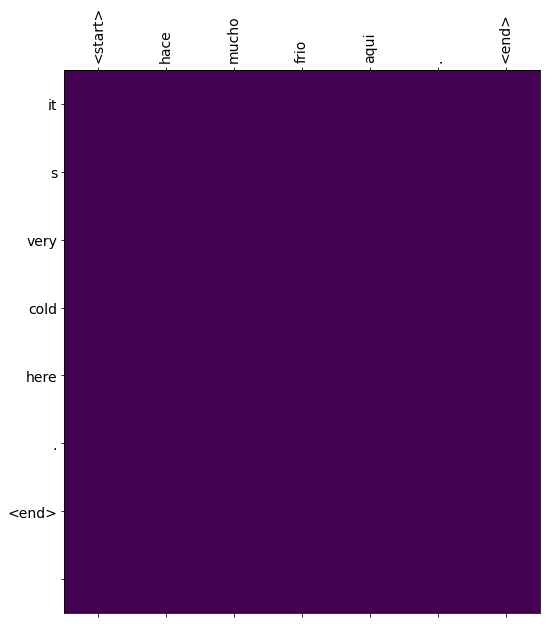

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


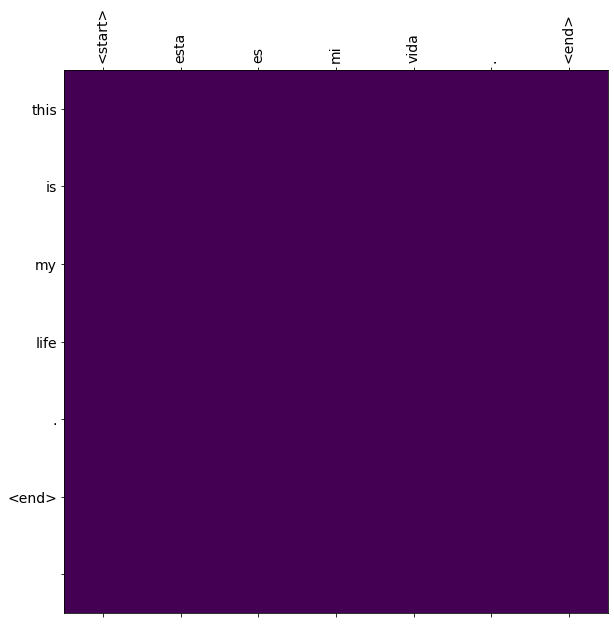

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


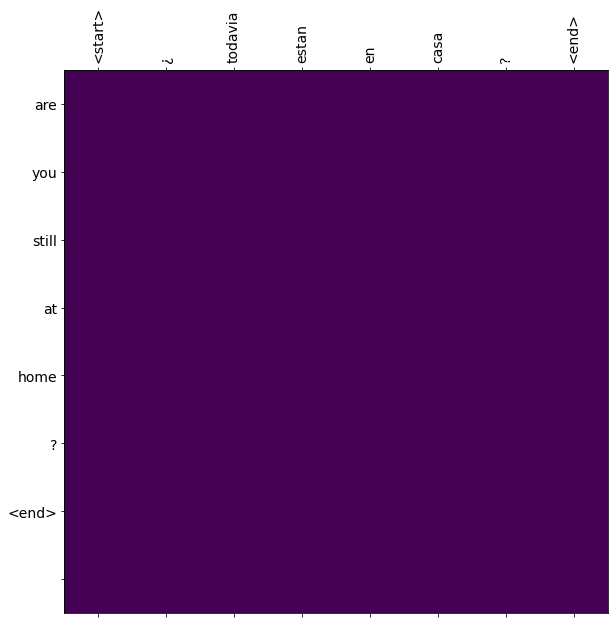

In [ ]:
translate(u'¿todavia estan en casa?')

# Tensorflow.Keras의 model.fit() Vs. Tensorflow Gradient Tape

케라스의 model.fit()과 Gradient Tape()를 사용한 구현의 차이를 이해해봅시다.

##in Tensorflow.Keras

In [ ]:
'''
# 신경망 모델 만들기
model = tf.keras.models.Sequential()
# 완전 연결층을 추가
model.add(tf.keras.layers.Dense(1))
# 옵티마이저와 손실 함수를 지정합니다.
model.compile(optimizer = 'sgd', loss = 'mse')
# 훈련 데이터를 사용하여 에포크 횟수만큼 훈련
model.fit(x_train, y_train, epochs = 10)
'''

"\n# 신경망 모델 만들기\nmodel = tf.keras.models.Sequential()\n# 완전 연결층을 추가\nmodel.add(tf.keras.layers.Dense(1))\n# 옵티마이저와 손실 함수를 지정합니다.\nmodel.compile(optimizer = 'sgd', loss = 'mse')\n# 훈련 데이터를 사용하여 에포크 횟수만큼 훈련\nmodel.fit(x_train, y_train, epochs = 10)\n"

## in Tensorflow

tape_gradient() 메서드는 자동 미분 기능을 수행합니다.  
자동 미분에 대해서 실습을 통해 이해해봅시다. 임의로 2w^2+5라는 식을 세워보고, w에 대해 미분해보겠습니다.

In [ ]:
w = tf.Variable(2.)

def f(w):
  y = w**2
  z = 2*y + 5
  return z

이제 gradients를 출력하면 w가 속한 수식을 w로 미분한 값이 저장된 것을 확인할 수 있습니다.

In [ ]:
with tf.GradientTape() as tape:
  z = f(w)

gradients = tape.gradient(z, [w])
print(gradients)

[<tf.Tensor: shape=(), dtype=float32, numpy=8.0>]


In [ ]:
'''
# 훈련할 가중치 변수를 선언
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

# 경사 하강법 옵티마이저 설정
optimizer = tf.optimizer.SGD(lr = 0.01)
# 에포크만큼 훈련
num_epochs = 10
for step in range(num_epochs):
   
    # 예측을 해서 손실을 구하는 과정입니다. (자동 미분을 위해 연산 과정을 기록합니다.)
    # tape_gradient() 메서드를 사용하면 그래디언트를 자동으로 계산할 수 있도록 합니다.
    with tf.GradientTape() as tape:
        z_net = w * x_train + b # 정방향 계산
        z_net = tf.reshape(z_net, [-1])
        sqr_errors = tf.square(y_train - z_net)
        mean_cost = tf.reduce_mean(sqr_errors) # 손실을 계산

    # 경사하강법으로 파라미터를 업데이트하는 과정입니다.
    # 1. 가중치에 대한 그래디언트 계산
    grads = tape.gradient(mean_cost, [w, b])

    # 2. 가중치를 업데이트
    # apply_gradients() 메서드에는 그래디언트와 가중치를 튜플로 묶은 리스트를 전달해야 합니다.
    # 보통 zip()을 주로 사용합니다.
    optimizer.apply_gradient(zip(grads, [w, b]))
'''

'\n# 훈련할 가중치 변수를 선언\nw = tf.Variable(tf.zeros(shape=(1)))\nb = tf.Variable(tf.zeros(shape=(1)))\n\n# 경사 하강법 옵티마이저 설정\noptimizer = tf.optimizer.SGD(lr = 0.01)\n# 에포크만큼 훈련\nnum_epochs = 10\nfor step in range(num_epochs):\n   \n    # 예측을 해서 손실을 구하는 과정입니다. (자동 미분을 위해 연산 과정을 기록합니다.)\n    # tape_gradient() 메서드를 사용하면 그래디언트를 자동으로 계산할 수 있도록 합니다.\n    with tf.GradientTape() as tape:\n        z_net = w * x_train + b # 정방향 계산\n        z_net = tf.reshape(z_net, [-1])\n        sqr_errors = tf.square(y_train - z_net)\n        mean_cost = tf.reduce_mean(sqr_errors) # 손실을 계산\n\n    # 경사하강법으로 파라미터를 업데이트하는 과정입니다.\n    # 1. 가중치에 대한 그래디언트 계산\n    grads = tape.gradient(mean_cost, [w, b])\n\n    # 2. 가중치를 업데이트\n    # apply_gradients() 메서드에는 그래디언트와 가중치를 튜플로 묶은 리스트를 전달해야 합니다.\n    # 보통 zip()을 주로 사용합니다.\n    optimizer.apply_gradient(zip(grads, [w, b]))\n'

# 텐서플로우 애드온을 이용한 seq2seq

어텐션 메커니즘과 상관없이 시간이 남으면 보여드리기 위해 추가한 분량.

In [ ]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [ ]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [ ]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "01234567890, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy01234567890, '

In [ ]:
OUTPUT_CHARS = "0123456789-"

In [ ]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [ ]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[7, 11, 19, 22, 11, 16, 9, 11, 20, 38, 28, 26, 37, 38, 33, 26, 33, 31]

In [ ]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [ ]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [ ]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [ ]:
print(X_train[0])
print(Y_train[0])

tf.Tensor([ 8 12 20 23 12 17 10 12 21 39 29 27 38 39 34 27 34 32], shape=(18,), dtype=int32)
tf.Tensor([ 8  1  8  6 11  1 10 11  3  1], shape=(10,), dtype=int32)


In [ ]:
from tensorflow import keras

텐서플로우 애드온 프로젝트는 여러가지 seq2seq 도구를 포함하고 있어 제품 수준의 seq2seq를 쉽게 만들 수 있음.  
우선 인코더의 LSTM에서 return_state=True를 사용한 이후는 디코더에 hidden state를 전달하기 위함.  
LSTM을 사용하므로 cell state, hidden state 두 개를 반환.  

TrainingSampler는 텐서플로우 애드온에 포함되어져 있는 여러 샘플러 중 하나.  
이 샘플러는 각 스텝에서 디코더에게 이전 스텝의 출력이 무엇이었는지 알려줌.  
훈련 시에는 이전 타깃 토큰의 임베딩,  
테스트 시에는 실제로 출력되는 토큰의 임베딩.  

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [ ]:
print(Y_train[0])
print(X_train_decoder[0]) # 종료 토큰 제거 후 시작 토큰 추가

tf.Tensor([ 8  1  8  6 11  1 10 11  3  1], shape=(10,), dtype=int32)
tf.Tensor([12  8  1  8  6 11  1 10 11  3], shape=(10,), dtype=int32)


In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

ModuleNotFoundError: ignored

In [ ]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

In [ ]:
max_output_length = Y_train.shape[1]

In [ ]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict_classes(X)
    return ids_to_date_strs(ids)

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

LSTM ver : https://colab.research.google.com/drive/1tpDiv4RtH9Um6StAkUUPbW0ETWv1vPy3?usp=sharing